In [12]:
import functions, datasets

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

import scipy
import sklearn

sns.set(color_codes=True)

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
from influence.smooth_hinge import SmoothHinge
import influence.dataset as dataset
from influence.dataset import DataSet

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def examine_vec(x, verbose=False):
    assert len(feature_names) == len(x)
    print('Age: %s' % x[age_var_indices])
    if verbose:
        for feature_name, val in zip(feature_names, x):
            print('%32s: %.6f' % (feature_name, val))
    
def examine_train_point(idx, verbose=False):
    print('Label: %s' % Y_train[idx])
    examine_vec(modified_X_train[idx, :], verbose)
    
def examine_test_point(idx, verbose=False):
    print('Label: %s' % Y_test[idx])
    examine_vec(X_test[idx, :], verbose)

# Read and process dataset

In [17]:
df = pd.read_csv('diabetic_data.csv')
# Use this if you are not running this in CodaLab
# df = pd.read_csv('../data/diabetic_data.csv')

In [18]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [19]:
# Convert categorical variables into numeric ones

X = pd.DataFrame()

# Numerical variables that we can pull directly
X = df.loc[
    :, 
    [
        'time_in_hospital',
        'num_lab_procedures',
        'num_procedures',
        'num_medications',
        'number_outpatient',
        'number_emergency',
        'number_inpatient',
        'number_diagnoses'
    ]]

categorical_var_names = [
    'gender',
    'race',
    'age', 
    'discharge_disposition_id',
    'max_glu_serum',
    'A1Cresult',
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'examide',
    'citoglipton',
    'insulin',
    'glyburide-metformin',
    'glipizide-metformin',
    'glimepiride-pioglitazone',
    'metformin-rosiglitazone',
    'metformin-pioglitazone',
    'change',
    'diabetesMed'
]
for categorical_var_name in categorical_var_names:
    categorical_var = pd.Categorical(
        df.loc[:, categorical_var_name])
    
    # Just have one dummy variable if it's boolean
    if len(categorical_var.categories) == 2:
        drop_first = True
    else:
        drop_first = False

    dummies = pd.get_dummies(
        categorical_var, 
        prefix=categorical_var_name,
        drop_first=drop_first)
    
    X = pd.concat([X, dummies], axis=1)

In [20]:
### Set the Y labels
readmitted = pd.Categorical(df.readmitted)

Y = np.copy(readmitted.codes)

# Combine >30 and 0 and flip labels, so 1 (>30) and 2 (No) become -1, while 0 becomes 1
Y[Y >= 1] = -1
Y[Y == 0] = 1

# Map to feature names
feature_names = X.columns.values

### Find indices of age features
age_var = pd.Categorical(df.loc[:, 'age'])
age_var_names = ['age_%s' % age_var_name for age_var_name in age_var.categories]    
age_var_indices = []
for age_var_name in age_var_names:
    age_var_indices.append(np.where(X.columns.values == age_var_name)[0][0])
age_var_indices = np.array(age_var_indices, dtype=int)

In [21]:
### Split into training and test sets. 
# For convenience, we balance the training set to have 10k positives and 10k negatives.

np.random.seed(2)
num_examples = len(Y)
assert X.shape[0] == num_examples
num_train_examples = 20000
num_train_examples_per_class = int(num_train_examples / 2)
num_test_examples = num_examples - num_train_examples
assert num_test_examples > 0

pos_idx = np.where(Y == 1)[0]
neg_idx = np.where(Y == -1)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)
assert len(pos_idx) + len(neg_idx) == num_examples

train_idx = np.concatenate((pos_idx[:num_train_examples_per_class], neg_idx[:num_train_examples_per_class]))
test_idx = np.concatenate((pos_idx[num_train_examples_per_class:], neg_idx[num_train_examples_per_class:]))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

X_train = np.array(X.iloc[train_idx, :], dtype=np.float32)
Y_train = Y[train_idx]

X_test = np.array(X.iloc[test_idx, :], dtype=np.float32)
Y_test = Y[test_idx]

train = DataSet(X_train, Y_train)
validation = None
test = DataSet(X_test, Y_test)
data_sets = base.Datasets(train=train, validation=validation, test=test)

lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

test_children_idx = np.where(X_test[:, age_var_indices[0]] == 1)[0]

In [22]:
y_train = Y_train
y_test = Y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20000, 127), (20000,), (81766, 127), (81766,))

In [36]:
num_train_examples = X_train.shape[0]
input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 10000
use_bias = True

C_minus_one = 1.0 / ((num_train_examples - 1) * weight_decay)
clf = LogisticRegression(
    C=C_minus_one,
    tol=1e-8,
    fit_intercept=False, 
    solver='lbfgs',
    multi_class='multinomial',
    warm_start=True, #True
    max_iter=max_lbfgs_iter)  

In [37]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.5000250012500626, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=1e-08, verbose=0,
          warm_start=True)

In [41]:
y_test = Y_test

In [43]:
y_train_pred = clf.predict(X_train)
wrong = np.zeros(y_train.shape)
wrong[y_train!=y_train_pred] = 1
acc = 1 - np.count_nonzero(y_train-y_train_pred)/y_train.shape[0]
print("Train Accuracy:",acc)

y_test_pred = clf.predict(X_test)
test_wrong = np.zeros(y_test.shape)
test_wrong[y_test!=y_test_pred] = 1
test_acc = 1 - np.count_nonzero(y_test-y_test_pred)/y_test.shape[0]
print("Test Accuracy:",test_acc)

Train Accuracy: 0.6242
Test Accuracy: 0.6803561382481715


In [44]:
# Remove from the training set all but one young patients who didn't get readmitted 
mask_to_remove = (Y_train == -1) & (X_train[:, age_var_indices[0]] == 1) 
idx_to_remove = np.where(mask_to_remove)[0][:-1] # Keep 1 of them
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = np.copy(X_train)
modified_Y_train = np.copy(Y_train)

modified_X_train = modified_X_train[mask_to_keep, :]
modified_Y_train = modified_Y_train[mask_to_keep]

print('In original data, %s/%s children were readmitted.' % (
        np.sum((Y_train == 1) & (X_train[:, age_var_indices[0]] == 1)),
        np.sum((X_train[:, age_var_indices[0]] == 1))))
print('In modified data, %s/%s children were readmitted.' % (
        np.sum((modified_Y_train == 1) & (modified_X_train[:, age_var_indices[0]] == 1)),
        np.sum((modified_X_train[:, age_var_indices[0]] == 1))))

# modified_train = DataSet(modified_X_train, modified_Y_train)
# validation = None
# test = DataSet(X_test, Y_test)
# modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)


# lr_modified_train = DataSet(modified_X_train, np.array((modified_Y_train + 1) / 2, dtype=int))
# lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

In original data, 3/24 children were readmitted.
In modified data, 3/4 children were readmitted.


In [45]:
import copy
clf2 = copy.copy(clf)
clf2.fit(modified_X_train, modified_Y_train)

LogisticRegression(C=0.5000250012500626, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=1e-08, verbose=0,
          warm_start=True)

In [46]:
y_train_pred2 = clf2.predict(X_train)
wrong = np.zeros(y_train.shape)
wrong[y_train!=y_train_pred2] = 1
acc = 1 - np.count_nonzero(y_train-y_train_pred2)/y_train.shape[0]
print("Train Accuracy:",acc)

y_test_pred2 = clf2.predict(X_test)
test_wrong = np.zeros(y_test.shape)
test_wrong[y_test!=y_test_pred2] = 1
test_acc = 1 - np.count_nonzero(y_test-y_test_pred2)/y_test.shape[0]
print("Test Accuracy:",test_acc)

Train Accuracy: 0.62355
Test Accuracy: 0.6799525475136365


In [47]:
# Find children in the test set and see how predictions change on them
true_labels = Y_test[test_children_idx]

orig_model_preds = clf.predict_proba(X_test)[:,0]
modified_model_preds = clf2.predict_proba(X_test)[:,0]

print(orig_model_preds.shape)

for i in range(len(test_children_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_children_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

(81766,)
index 473, label -1: 0.9870921429830902 vs. 0.9870909050705315
index 647, label -1: 0.9828662040879483 vs. 0.9829165126836178
index 1037, label -1: 0.4143081554529367 vs. 0.41443652172120443
index 1599, label -1: 0.6420962781639855 vs. 0.6421079332045081
index 1611, label -1: 0.4429727670594578 vs. 0.443132339871574
index 1742, label -1: 0.2332164007938807 vs. 0.23505429412982506
index 2119, label -1: 0.7627744399916112 vs. 0.7617415983664483
index 2623, label -1: 0.16981526882977363 vs. 0.17002489641500557
index 4901, label -1: 0.32954929818017775 vs. 0.32971034474975375
index 6120, label -1: 0.6575774675639303 vs. 0.6566881129716409
index 6160, label -1: 0.630785979322452 vs. 0.6297836049039536
index 6997, label -1: 0.5723898841202211 vs. 0.5722709537294018
index 7062, label -1: 0.6096892379835362 vs. 0.6088269921098624
index 7619, label -1: 0.3113996388190425 vs. 0.31226289320160744
index 9026, label -1: 0.494434917352757 vs. 0.4952536112743273
index 9345, label -1: 0.47633

index 76070, label -1: 0.45471743685926985 vs. 0.45488141644312546
index 76250, label -1: 0.5151259645264392 vs. 0.5148674876642229
index 76627, label -1: 0.5402095980995567 vs. 0.5415592467373823
index 77527, label -1: 0.484939768203829 vs. 0.48589733011299935
index 77959, label -1: 0.532958799509115 vs. 0.5333731536726793
index 78098, label -1: 0.6080761341292119 vs. 0.6066922910646217
index 79909, label -1: 0.5838952391350872 vs. 0.5849179295889902
index 80509, label -1: 0.5540031893082447 vs. 0.5538904822988138
index 80828, label -1: 0.4563372696850227 vs. 0.45623623178144707
index 81437, label -1: 0.5013665046026433 vs. 0.5018271548321024
index 81705, label -1: 0.6336145861126383 vs. 0.6338995009505443


In [11]:
all_influences = functions.calculate_influences_on_trust_remove(clf, X_train, y_train, X_trust, y_trust, all=False)
all_influences.shape

(7, 340)

In [12]:
n = 10
top_n = True
data.plot_influences(X_train, y_train, all_influences, n, top_n, X_trust, y_trust)

In [ ]:
pr = True
functions.plot_pr_curves(all_influences, true_bugs, PR=pr, title=None)

In [23]:
# Train a model on the training set

num_classes = 2

input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
use_bias = True

tf.reset_default_graph()

orig_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

orig_model.train()

orig_model_preds = orig_model.sess.run(
    orig_model.preds,
    feed_dict=orig_model.all_test_feed_dict)
orig_model_preds = orig_model_preds[test_children_idx, 0]

Total number of parameters: 127


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.64229584
Train loss (w/o reg) on all data: 0.6412036
Test loss (w/o reg) on all data: 0.6529927
Train acc on all data:  0.62385
Test acc on all data:   0.6818359709414671
Norm of the mean of gradients: 0.0010109771
Norm of the params: 4.673857


In [27]:
# Remove from the training set all but one young patients who didn't get readmitted 
mask_to_remove = (Y_train == -1) & (X_train[:, age_var_indices[0]] == 1) 
idx_to_remove = np.where(mask_to_remove)[0][:-1] # Keep 1 of them
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = np.copy(X_train)
modified_Y_train = np.copy(Y_train)

modified_X_train = modified_X_train[mask_to_keep, :]
modified_Y_train = modified_Y_train[mask_to_keep]

print('In original data, %s/%s children were readmitted.' % (
        np.sum((Y_train == 1) & (X_train[:, age_var_indices[0]] == 1)),
        np.sum((X_train[:, age_var_indices[0]] == 1))))
print('In modified data, %s/%s children were readmitted.' % (
        np.sum((modified_Y_train == 1) & (modified_X_train[:, age_var_indices[0]] == 1)),
        np.sum((modified_X_train[:, age_var_indices[0]] == 1))))

modified_train = DataSet(modified_X_train, modified_Y_train)
validation = None
test = DataSet(X_test, Y_test)
modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)


lr_modified_train = DataSet(modified_X_train, np.array((modified_Y_train + 1) / 2, dtype=int))
lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

In original data, 3/24 children were readmitted.
In modified data, 3/4 children were readmitted.


In [28]:
# Train a model on the modified training set
tf.reset_default_graph()

modified_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_modified_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

modified_model.train()

modified_model_preds = modified_model.sess.run(
    modified_model.preds,
    feed_dict=modified_model.all_test_feed_dict)
modified_model_preds = modified_model_preds[test_children_idx, 0]
modified_theta = modified_model.sess.run(modified_model.params)[0]

Total number of parameters: 127


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.6426071
Train loss (w/o reg) on all data: 0.6415087
Test loss (w/o reg) on all data: 0.6537577
Train acc on all data:  0.6243743743743744
Test acc on all data:   0.6813712300956388
Norm of the mean of gradients: 0.0009771496
Norm of the params: 4.687034


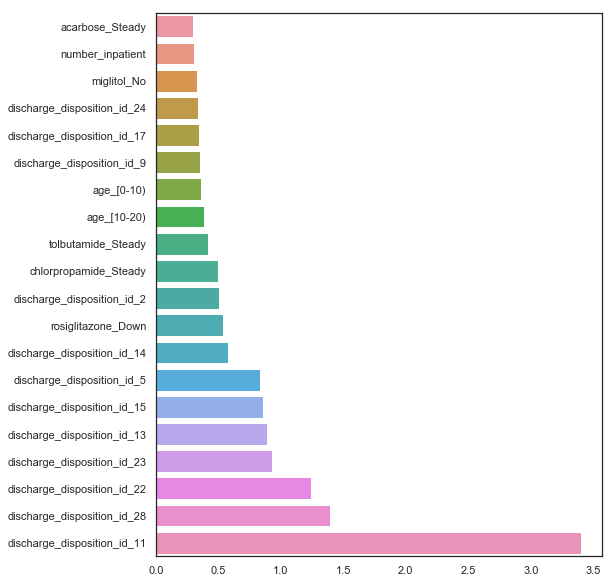

In [29]:
# Baseline: look at coefficient values
sns.set_style('white')
plt.figure(figsize=(8, 10))
idx = np.argsort(np.abs(modified_theta))[-20:]
sns.barplot(np.abs(modified_theta[idx]), X.columns.values[idx])

In [30]:
# Find children in the test set and see how predictions change on them
true_labels = Y_test[test_children_idx]

for i in range(len(test_children_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_children_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

index 473, label -1: 0.8024674 vs. 0.5668819
index 647, label -1: 0.8348741 vs. 0.6184955
index 1037, label -1: 0.78033906 vs. 0.53332806
index 1599, label -1: 0.78071547 vs. 0.5336199
index 1611, label -1: 0.806191 vs. 0.5726674
*** index 1742, label -1: 0.72198325 vs. 0.4557631
index 2119, label -1: 0.81580025 vs. 0.586512
index 2623, label -1: 0.78843594 vs. 0.5446295
index 4901, label -1: 0.7627556 vs. 0.50891817
index 6120, label -1: 0.83239853 vs. 0.6142676
index 6160, label -1: 0.81968 vs. 0.5931083
index 6997, label -1: 0.8245501 vs. 0.6012052
index 7062, label -1: 0.78942066 vs. 0.5463796
index 7619, label -1: 0.8245013 vs. 0.6011989
index 9026, label -1: 0.8149972 vs. 0.5866894
index 9345, label -1: 0.8277682 vs. 0.60641986
index 9448, label -1: 0.80999553 vs. 0.5791558
index 10163, label -1: 0.858738 vs. 0.661439
index 10247, label -1: 0.8205432 vs. 0.5947495
index 10637, label -1: 0.83158123 vs. 0.6157683
index 11036, label -1: 0.8304872 vs. 0.61097944
index 11599, label -1

In [31]:
# Pick one of those children and find the most influential examples on it
test_idx = 1742
x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]
print("Test point features:")
print(x_test)
print(y_test)
print('Younger than 10? %s' % x_test[age_var_indices[0]])

influences = modified_model.get_influence_on_test_loss(
    test_indices=[1742],
    train_idx=np.arange(len(modified_model.data_sets.train.labels)))

top_k = 10
helpful_points = np.argsort(influences)[-top_k:][::-1]
unhelpful_points = np.argsort(influences)[:top_k]

influences_to_plot = []
ages_to_plot = []

for points, message in [
    (unhelpful_points, 'worse'), (helpful_points, 'better')]:
    print("Top %s training points making the loss on the test point %s:" % (top_k, message))
    for counter, idx in enumerate(points):
        print("#%5d, class=%s, age=%s, predicted_loss_diff=%.8f" % (
            idx,                 
            modified_Y_train[idx], 
            modified_X_train[idx, age_var_indices],
            influences[idx]))
        
        ages_to_plot.append(idx)
        influences_to_plot.append(influences[idx])


Test point features:
[ 1. 55.  0. 10.  0.  0.  1.  3.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.]
-1
Younger than 10? 1.0
Norm of test gradient: 30.588825
Function value: 208.30311584472656
Split function value: 243.5022430419922, -35.199127
Predicted loss diff on train_idx 5: -0.000574388351287689
Function value: -4.156877517700195
Split function value: 5.867430686950684, -10.024308
Predicted loss diff on train_idx 5: -0.000126533250550966
Function value: -4.316900730133057
Split function value: 5.00931978225708, -9.3262205
Predicted loss diff on train_

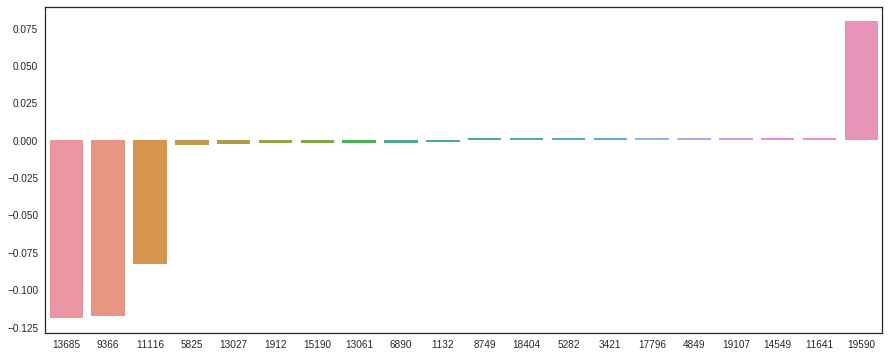

In [23]:
# The children in the modified dataset are by far the most influential
plt.figure(figsize=(15,6))
sort_idx = np.argsort(influences_to_plot)
ages_to_plot = np.array(ages_to_plot)
sns.barplot(ages_to_plot, influences_to_plot, order=ages_to_plot[sort_idx])

Norm of test gradient: 30.045
Loaded inverse HVP from output/diabetes_logreg-cg-normal_loss-test-[1742].npz
Inverse HVP took 0.00241303443909 sec


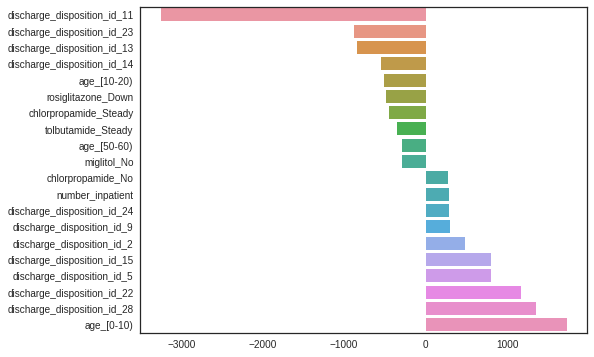

In [24]:
# Look at which features are causing this influence
grad_influences_wrt_input_val = modified_model.get_grad_of_influence_wrt_input(
    [19590, 13685, 9366, 11116], 
    [test_idx], 
    force_refresh=False,
    test_description=None,
    loss_type='normal_loss')    

delta = grad_influences_wrt_input_val[0, :]
plt.figure(figsize=(8, 6))
idx_to_plot = np.array([0] * len(delta), dtype=bool)
idx_to_plot[:10] = 1
idx_to_plot[-10:] = 1
sns.barplot(np.sort(delta)[idx_to_plot], feature_names[np.argsort(delta)[idx_to_plot]], orient='h')